In [1]:
from fdfdpy import Simulation

import sys
sys.path.append("..")

from optimization import Optimization
from structures import two_port

import numpy as np
import matplotlib.pylab as plt
import scipy.sparse as sp

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# fundamental constants and simulation parameters
lambda0 = 2e-6              # free space wavelength (m)
c0 = 3e8                    # speed of light in vacuum (m/s)
omega = 2*np.pi*c0/lambda0  # angular frequency (2pi/s)
dl = 1e-1                   # grid size (L0)
NPML = [15, 15]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')
source_amp = 20              # amplitude of modal source (A/L0^2?)

In [3]:
# material constants
n_index = 2.44              # refractive index
eps_m = n_index**2          # relative permittivity
chi3 = 4.1*1e-19            # Al2S3 from Boyd (m^2/V^2)
max_ind_shift = 6e-3      # maximum allowed nonlinear refractive index shift (computed from damage threshold)

In [4]:
# geometric parameters
L = 20         # length of design region (L0)
H = 5         # height of design region (L0)
w = 0.5        # width of waveguides (L0)
l = 4         # length of waveguide from PML to design region (L0)
spc = 2     # space between box and PML (L0)

Computed a domain with 310 grids in x and 120 grids in y
The simulation has 20 grids per free space wavelength


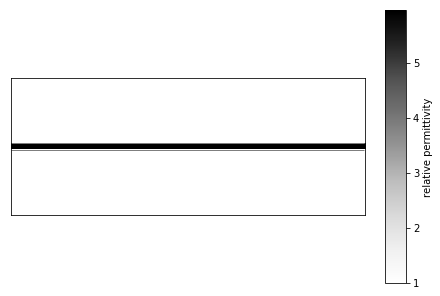

In [5]:
# define permittivity of two port system
eps_r, design_region = two_port(L, H, w, l, spc, dl, NPML, eps_start=eps_m)
(Nx, Ny) = eps_r.shape
nx, ny = int(Nx/2), int(Ny/2)            # halfway grid points

simulation = Simulation(omega, eps_r, dl, NPML, pol)
# compute the grid size the total grid size
print("Computed a domain with {} grids in x and {} grids in y".format(Nx,Ny))
print("The simulation has {} grids per free space wavelength".format(int(lambda0/dl/simulation.L0)))
simulation.plt_eps()
plt.show()

In [6]:
# set the modal source and probes
simulation = Simulation(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny], int(Ny/2), scale=source_amp)
simulation.setup_modes()
print('Calculate an input power of {} Watts/L0'.format(simulation.W_in))

# out modal profile
sim_out = Simulation(omega, eps_r, dl, NPML, 'Ez')
sim_out.add_mode(np.sqrt(eps_m), 'x', [-NPML[0]-int(l/2/dl), ny], int(Ny/2))
sim_out.setup_modes()
J_out = np.abs(sim_out.src)

# in modal profile
sim_in = Simulation(omega, eps_r, dl, NPML, 'Ez')
sim_in.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l*2/3/dl), ny], int(Ny/2))
sim_in.setup_modes()
J_in = np.abs(sim_in.src)

Calculate an input power of 7.023389836643965 Watts/L0


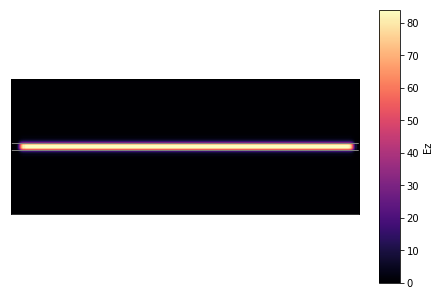

In [7]:
# set source and solve for electromagnetic fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs(outline=True, cbar=True);

In [8]:
chi3 = 2.8*1e-18                           # Silcion in m^2/V^2 from Boyd's book
import copy
nl_region = copy.deepcopy(design_region)

simulation.nonlinearity = []  # This is needed in case you re-run this cell, for example (or you can re-initialize simulation every time)
simulation.add_nl(chi3, nl_region, eps_scale=True, eps_max=eps_m)

### First let's try to make a cavity

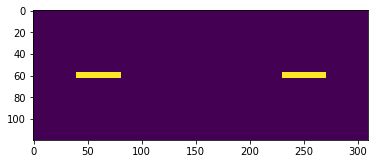

In [9]:
Jcent = np.zeros(eps_r.shape)
Jcent[nx, ny] = 1
J = {}
J['linear']    = lambda e, eps_r:  np.sum(np.square(np.abs(e))*Jcent)
dJ = {}
dJ['dE_linear']    = lambda e, eps_r:  np.conj(e)*Jcent

des_cavity = np.array(eps_r > 1).astype(int)
des_cavity[0:40, :] = 0
des_cavity[81:230, :] = 0
des_cavity[271:, :] = 0
plt.imshow(des_cavity.T)
plt.show()

In [17]:
# optimization parameters
Nsteps =  100
step_size = 1e-1
solver = 'newton'
opt_method = 'adam'

# initialize an optimization object with the above parameters and objective function information
simulation.eps_r = eps_r
optimization = Optimization(Nsteps=Nsteps, J=J, dJ=dJ, eps_max=eps_m, step_size=step_size,
                            solver=solver, opt_method=opt_method)

# check the derivatives
(grad_avm, grad_num) = optimization.check_deriv_lin(simulation, des_cavity)
print('differences: = \n{}'.format([abs(a - n) for a, n in zip(grad_avm, grad_num)]))

differences: = 
[3.3533242294048193e-09, 7.151862435605949e-12, 7.062336548901982e-10, 5.505724584575766e-09, 1.6556513937615591e-09]


In [11]:
# run the optimization with the simulation and the region and nonlinearity information
eps_cav = optimization.run(simulation, des_cavity)

100% (100 of 100) |######################| Elapsed Time: 0:01:46 ETA:  00:00:00

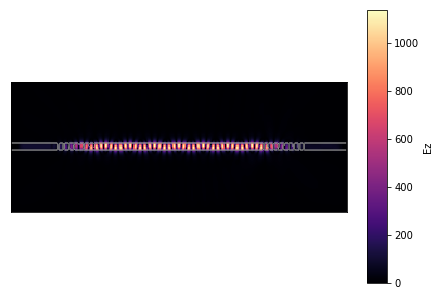

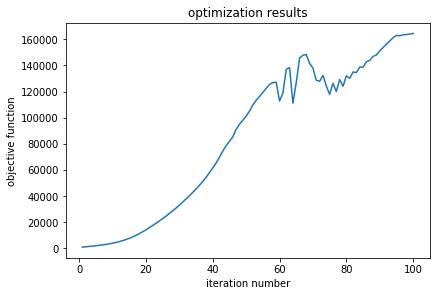

In [12]:
# set source and solve for electromagnetic fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs(outline=True, cbar=True);
optimization.plt_objs(scaled='W_in')
plt.show()

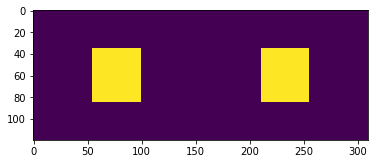

In [13]:
# Or try this
des_cavity1 = copy.deepcopy(design_region)
des_cavity1[100:211, :] = 0
plt.imshow(des_cavity1.T)
plt.show()

100% (200 of 200) |######################| Elapsed Time: 0:03:36 ETA:  00:00:00

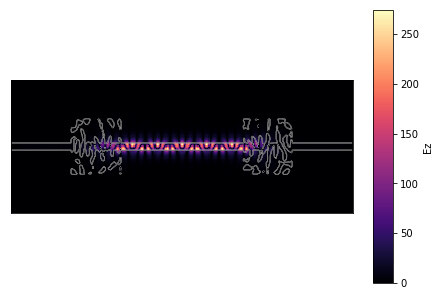

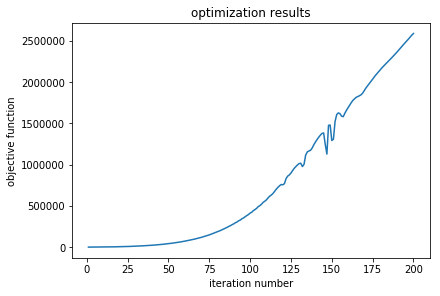

In [21]:
# optimization parameters
Nsteps =  200
step_size = 0.5e-1
solver = 'newton'
opt_method = 'adam'

# initialize an optimization object with the above parameters and objective function information
simulation.eps_r = eps_r
optimization = Optimization(Nsteps=Nsteps, J=J, dJ=dJ, eps_max=eps_m, step_size=step_size,
                            solver=solver, opt_method=opt_method)
# run the optimization with the simulation and the region and nonlinearity information
eps_cav1 = optimization.run(simulation, des_cavity1)
# set source and solve for electromagnetic fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs(outline=True, cbar=True);
optimization.plt_objs(scaled='W_in')
plt.show()

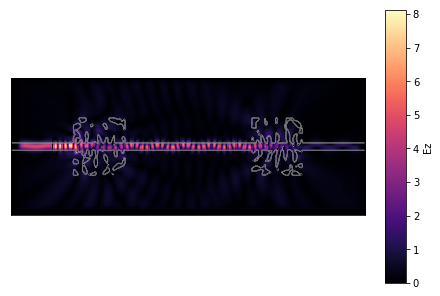

In [15]:
simulation.eps_r = eps_cav1
simulation.modes= []
simulation.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny], int(Ny/2), scale=1)
simulation.setup_modes()
simulation.nonlinearity = []  # This is needed in case you re-run this cell, for example (or you can re-initialize simulation every time)
simulation.add_nl(chi3, nl_region, eps_scale=True, eps_max=eps_m)
(Hx,Hy,Ez,_) = simulation.solve_fields_nl()
simulation.plt_abs(outline=True, cbar=True);

In [96]:
# compute powers

# input power
W_in = simulation.W_in

# linear powers
(Hx,Hy,Ez) = simulation.solve_fields()
W_out_lin = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny], int(Ny/2))
W_in_lin = simulation.flux_probe('x', [NPML[0]+int(2*l/3/dl), ny], int(Ny/2))

T_lin = W_out_lin/W_in_lin

# nonlinear powers
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl()
W_out_nl = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny], int(Ny/2))
W_in_nl = simulation.flux_probe('x', [NPML[0]+int(2*l/3/dl), ny], int(Ny/2))

T_nl = W_out_nl/W_in_nl

print('difference of {} %'.format(100*abs(W_out_lin-W_out_nl)/W_out_lin))
print('linear transmission    = {}'.format(T_lin))
print('nonlinear transmission = {}'.format(T_nl))
print('difference of {} %'.format(100*abs(T_lin-T_nl)))

difference of 93.21019729330344 %
linear transmission    = 0.19882304845975327
nonlinear transmission = 0.14381478806484654
difference of 5.500826039490672 %


In [97]:
J = {}
J['linear']    = lambda e, eps_r:  np.sum(np.square(np.abs(e))*J_out)
J['nonlinear'] = lambda e, eps_r:  -np.sum(np.square(np.abs(e))*J_out)
J['total']     = lambda J_lin, J_nonlin: J_lin + J_nonlin

# define linear and nonlinear parts of dJdE + the total derivative form
dJ = {}
dJ['dE_linear']    = lambda e, eps_r:  np.conj(e)*J_out
dJ['dE_nonlinear'] = lambda e, eps_r:  -np.conj(e)*J_out
# dJ['dE_linear']    = lambda e, eps_r: np.conj(e)*J_out
# dJ['dE_nonlinear'] = lambda e, eps_r: -np.conj(e)*J_out
dJ['total']        = lambda J_lin, J_nonlin, dJ_lin, dJ_nonlin: dJ_lin + dJ_nonlin
print(J['linear'](Ez, eps_cav1), J['nonlinear'](Ez_nl, eps_cav1))

0.5419220194093852 -0.1944292545026349


In [151]:
# optimization parameters
Nsteps =  10
step_size = 1e-4
solver = 'newton'
opt_method = 'adam'

design_region1 = copy.deepcopy(design_region)
design_region1[0:100, :] = 0
design_region1[211:, :] = 0

# initialize an optimization object with the above parameters and objective function information
simulation.eps_r = eps_cav1
simulation.modes = []
simulation.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny], int(Ny/2), scale=0.5)
simulation.setup_modes()
simulation.nonlinearity = []  # This is needed in case you re-run this cell, for example (or you can re-initialize simulation every time)
simulation.add_nl(chi3, nl_region, eps_scale=True, eps_max=eps_m)
optimization = Optimization(Nsteps=Nsteps, J=J, dJ=dJ, eps_max=eps_m, step_size=step_size,
                            solver=solver, opt_method=opt_method)

# check the derivatives
(grad_avm, grad_num) = optimization.check_deriv_lin(simulation, design_region)
print('differences: = \n{}'.format([abs(a - n)/abs(a) for a, n in zip(grad_avm, grad_num)]))
# print(grad_avm)
(grad_avm, grad_num) = optimization.check_deriv_nonlin(simulation, design_region)
print('differences: = \n{}'.format([abs(a - n)/abs(a) for a, n in zip(grad_avm, grad_num)]))
# print(grad_avm)


differences: = 
[0.0003319461812261369, 1.001453509854138e-06, 4.824327261975614e-06, 2.848878532597227e-06, 0.057840872610064674]
differences: = 
[2.3469086239668445e-07, 4.666118046877014e-08, 3.123417467427142e-07, 3.3443700885653377e-07, 5.1813750134560656e-08]


In [152]:
# run the optimization with the simulation and the region and nonlinearity information
new_eps = optimization.run(simulation, design_region1)

100% (10 of 10) |########################| Elapsed Time: 0:00:48 ETA:  00:00:00

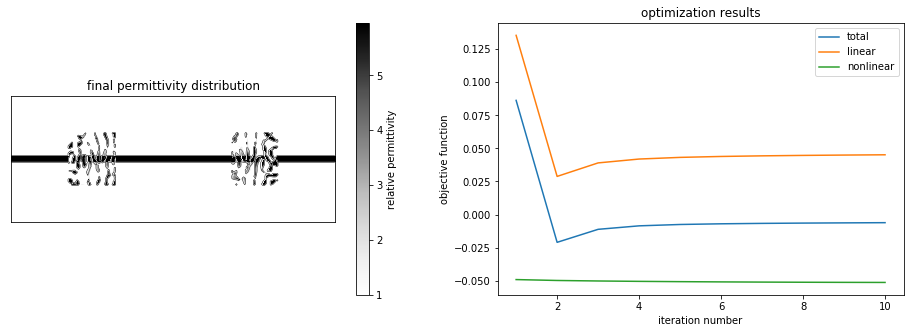

[0.0863280747668892, -0.02099142249040026, -0.011163683499845416, -0.008529029693875964, -0.007502057995313567, -0.00698550157152851, -0.006672271597812862, -0.006453407233200613, -0.006282326120148389, -0.006133672472761677]


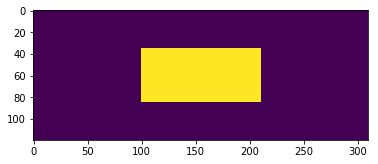

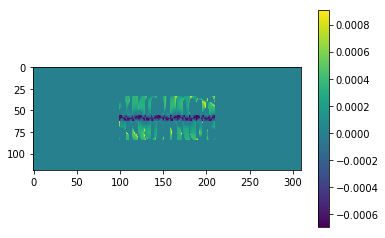

In [153]:
# plot optimization results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

# ax1.plot(optimization.W_in)
simulation.plt_eps(ax=ax1)
ax1.set_title('final permittivity distribution')

optimization.plt_objs(ax=ax2, scaled='1W_in')
# ax2.set_yscale('log')
plt.show()
print(optimization.objs_tot)
plt.imshow(design_region1.T)
plt.show()
plt.imshow((new_eps - eps_cav1).T)
plt.colorbar()
plt.show()

In [157]:
Jcent = np.zeros(eps_r.shape)
Jcent[nx, ny] = 1
J = {}
J['linear']    = lambda e, eps_r:  np.sum(np.square(np.abs(e))*Jcent)
dJ = {}
dJ['dE_linear']    = lambda e, eps_r:  np.conj(e)*Jcent

# initialize an optimization object with the above parameters and objective function information
simulation.eps_r = eps_cav1
simulation.modes = []
simulation.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny], int(Ny/2), scale=0.5)
simulation.setup_modes()
optimization = Optimization(Nsteps=100, J=J, dJ=dJ, eps_max=eps_m, step_size=step_size,
                            solver=solver, opt_method=opt_method)

# run the optimization with the simulation and the region and nonlinearity information
eps_cav2 = optimization.run(simulation, design_region1)

100% (100 of 100) |######################| Elapsed Time: 0:00:45 ETA:  00:00:00

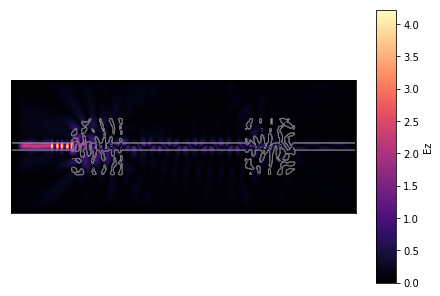

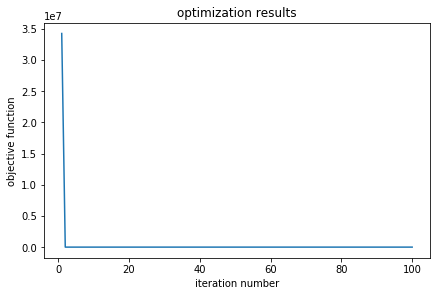

In [158]:
# set source and solve for electromagnetic fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs(outline=True, cbar=True);
optimization.plt_objs(scaled='W_in')
plt.show()

In [119]:
# compute powers

# input power
W_in = simulation.W_in

# linear powers
(Hx,Hy,Ez) = simulation.solve_fields()
W_out_lin = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny], int(Ny/2))
W_in_lin = simulation.flux_probe('x', [NPML[0]+int(2*l/3/dl), ny], int(Ny/2))

T_lin = W_out_lin/W_in_lin

# nonlinear powers
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl()
W_out_nl = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny], int(Ny/2))
W_in_nl = simulation.flux_probe('x', [NPML[0]+int(2*l/3/dl), ny], int(Ny/2))

T_nl = W_out_nl/W_in_nl

print('difference of {} %'.format(100*abs(W_out_lin-W_out_nl)/W_out_lin))
print('linear transmission    = {}'.format(T_lin))
print('nonlinear transmission = {}'.format(T_nl))
print('difference of {} %'.format(100*abs(T_lin-T_nl)))

difference of 46.138497005387755 %
linear transmission    = 0.13007204095314778
nonlinear transmission = 0.17390421286679328
difference of 4.383217191364549 %


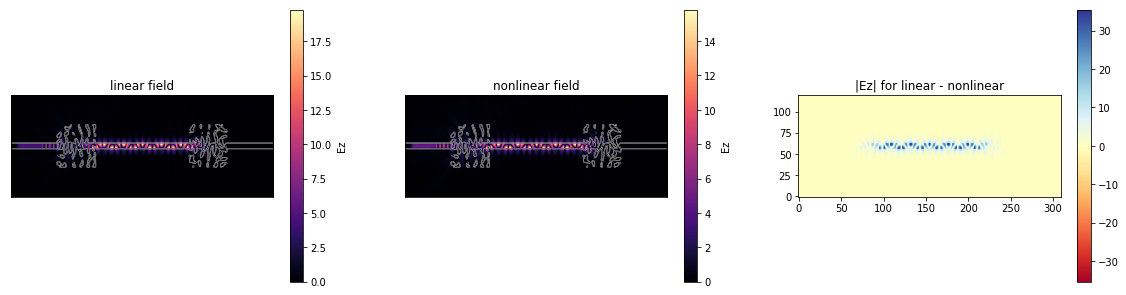

In [149]:
# compare the linear and nonlinear fields

# simulation.eps_r = new_eps

# setup subplots
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))

# linear fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs(ax=ax1, vmax=None)
ax1.set_title('linear field')

# nonlinear fields
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl()
simulation.plt_abs(ax=ax2, vmax=None)
ax2.set_title('nonlinear field')

# difference
difference = np.abs(Ez.T - Ez_nl.T)
im = plt.imshow(difference, vmin=-np.max(difference), vmax=np.max(difference), cmap='RdYlBu', origin='lower')
f.colorbar(im, ax=ax3)
ax3.set_title('|Ez| for linear - nonlinear')

plt.show()

maximum refractive index shift of 0.017217568046650065


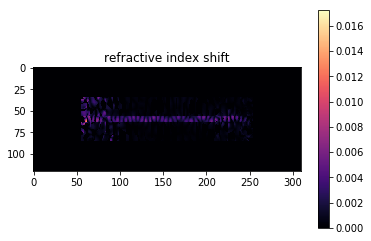

In [88]:
# compute the refractive index shift
index_shift = optimization.compute_index_shift(simulation)
print('maximum refractive index shift of {}'.format(np.max(index_shift)))
plt.imshow(index_shift.T, cmap='magma')
plt.colorbar()
plt.title('refractive index shift')
plt.show()

100% (10 of 10) |########################| Elapsed Time: 0:00:08 ETA:  00:00:00

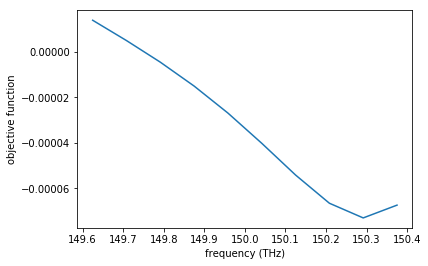

computed FWHM of 0.0 (THz):


In [89]:
freqs, objs, FWHM = optimization.scan_frequency(Nf=10, df=1/200)
optimization.simulation.omega = omega
plt.plot([f/1e12 for f in freqs], objs)
plt.xlabel('frequency (THz)')
plt.ylabel('objective function')
plt.show()
print('computed FWHM of {} (THz):'.format(FWHM/1e12))


In [90]:
# compute powers

# input power
W_in = simulation.W_in

# linear powers
(Hx,Hy,Ez) = simulation.solve_fields()
W_out_lin = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny], int(Ny/2))
W_in_lin = simulation.flux_probe('x', [NPML[0]+int(2*l/3/dl), ny], int(Ny/2))

T_lin = W_out_lin/W_in_lin

# nonlinear powers
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl()
W_out_nl = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny], int(Ny/2))
W_in_nl = simulation.flux_probe('x', [NPML[0]+int(2*l/3/dl), ny], int(Ny/2))

T_nl = W_out_nl/W_in_nl

print('difference of {} %'.format(100*abs(W_out_lin-W_out_nl)/W_out_lin))
print('linear transmission    = {}'.format(T_lin))
print('nonlinear transmission = {}'.format(T_nl))
print('difference of {} %'.format(100*abs(T_lin-T_nl)))


difference of 0.01148677468141285 %
linear transmission    = 0.07132320186627308
nonlinear transmission = 0.07132699756071113
difference of 0.00037956944380496127 %
